In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pywt

### Load Data

In [2]:
data = pd.read_csv('./dataset/data.csv')
data.sample(10)

,Image,Name
78,./dataset/cropped/kapil_dev/kapil_dev_9.jpg,kapil_dev
116,./dataset/cropped/kapil_dev/kapil_dev_47.jpg,kapil_dev
331,./dataset/cropped/sachin_tendulkar/sachin_tend...,sachin_tendulkar
108,./dataset/cropped/kapil_dev/kapil_dev_39.jpg,kapil_dev
174,./dataset/cropped/virat_kohli/virat_kohli_53.jpg,virat_kohli
229,./dataset/cropped/ms_dhoni/ms_dhoni_7.jpg,ms_dhoni
118,./dataset/cropped/kapil_dev/kapil_dev_49.jpg,kapil_dev
170,./dataset/cropped/virat_kohli/virat_kohli_49.jpg,virat_kohli
85,./dataset/cropped/kapil_dev/kapil_dev_16.jpg,kapil_dev
142,./dataset/cropped/virat_kohli/virat_kohli_21.jpg,virat_kohli


## Feature Engineering

### Wavelet Transform

In [3]:
# function to transform image using wavelet transform to extract features
def wavelet_transform(image, mode='haar', level=1):
    gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    normalized_img = np.float32(gray_img) / 255.0

    coefficients = pywt.wavedec2(normalized_img, mode, level=level)
    modified_coefficients = list(coefficients)
    modified_coefficients[0] *= 0

    reconstructed_img = pywt.waverec2(modified_coefficients, mode)
    final_img = np.uint8(reconstructed_img * 255.0)

    return final_img

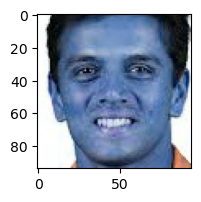

In [4]:
im = cv2.imread(data['Image'][0])
plt.figure(figsize=(10, 2))
plt.imshow(im)

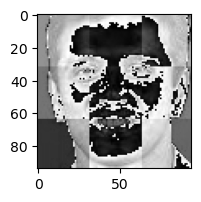

In [5]:
im_t = wavelet_transform(im, 'db1', 5)
plt.figure(figsize=(10, 2))
plt.imshow(im_t, cmap='gray')

In [6]:
def transform_all_images(data_dict: pd.DataFrame):
    X, y = [], []
    for i in range(len(data_dict)):
        img = cv2.imread(data_dict['Image'][i])
        transformed_img = wavelet_transform(img, 'db1', 5)

        reshaped_sr_img = np.reshape(cv2.resize(img, (32, 32)), (32*32*3, 1))   # reshaped scaled raw image
        reshaped_st_img = np.reshape(cv2.resize(transformed_img, (32, 32)), (32*32, 1)) # reshaped scaled transformed image

        combined_img = np.vstack((reshaped_sr_img, reshaped_st_img))

        X.append(combined_img)
        y.append(data_dict['Name'][i])
    return np.array(X), np.array(y)

In [7]:
X, y = transform_all_images(data)

In [8]:
X.shape

(390, 4096, 1)

In [9]:
X = X.reshape(X.shape[0], X.shape[1]).astype('float')
X.shape

(390, 4096)

## Training Model

### Label Encoding

In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

### Train Test Split

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4, stratify=y)

In [12]:
original_y = le.inverse_transform(y_test)
unique_labels, counts = np.unique(original_y, return_counts=True)
for label , count in zip(unique_labels, counts):
    print(f"{label}: {count} occurrences")

kapil_dev: 10 occurrences
ms_dhoni: 14 occurrences
rahul_dravid: 14 occurrences
sachin_tendulkar: 20 occurrences
virat_kohli: 20 occurrences


### Pipeline Scaling and Training

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel='rbf', C=10))])
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC(C=10))])

In [14]:
pipe.score(X_test, y_test)

0.7948717948717948

### Hyperparameter Tuning

In [15]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [16]:
svm = {
    'model': SVC(gamma='auto', probability=True),
    'params': {
        'svc__C': [1, 5, 10, 100],
        'svc__kernel': ['rbf', 'linear']
    }
}

In [17]:
print('Training with SVM')
pipe = make_pipeline(StandardScaler(), svm['model'])
classifier = GridSearchCV(pipe, svm['params'], cv=5)
classifier.fit(X_train, y_train)
score = {
    'model': 'SVM',
    'best_score': classifier.best_score_,
    'best_params': classifier.best_params_
}

Training with SVM


In [18]:
score

{'model': 'SVM',
 'best_score': 0.7725550435227854,
 'best_params': {'svc__C': 1, 'svc__kernel': 'linear'}}

### Evaluation

In [19]:
classifier.score(X_test, y_test)

0.8974358974358975

In [20]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, classifier.predict(X_test))
cm

array([[ 9,  0,  0,  1,  0],
       [ 0, 12,  0,  1,  1],
       [ 1,  1, 11,  1,  0],
       [ 0,  0,  2, 18,  0],
       [ 0,  0,  0,  0, 20]])

Text(50.722222222222214, 0.5, 'Truth')

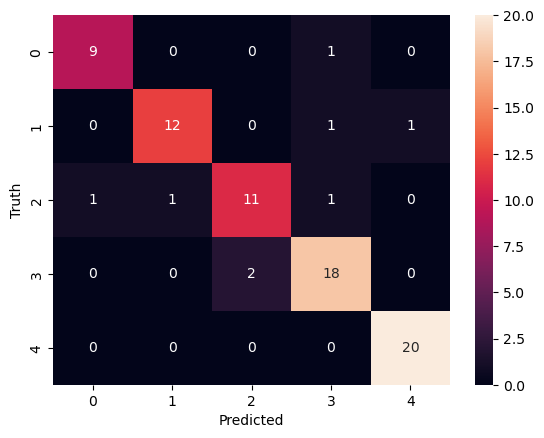

In [21]:
import seaborn as sns
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [22]:
le.inverse_transform([0, 1, 2, 3, 4])

array(['kapil_dev', 'ms_dhoni', 'rahul_dravid', 'sachin_tendulkar',
       'virat_kohli'], dtype='<U16')

### Save Model

In [23]:
import joblib
joblib.dump(classifier, '../server/artifacts/model.pkl')

['../server/artifacts/model.pkl']

In [24]:
joblib.dump(le, '../server/artifacts/label_encoder.pkl')

['../server/artifacts/label_encoder.pkl']